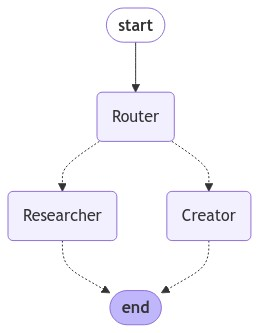

/mnt/c/Blog/WatsonX-Multi-Agent-System-with-Langraph/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


{'Router': {'messages': [AIMessage(content='Router Agent: Selected Researcher', name='Router')], 'sender': 'Router', 'user_query': 'Fetch the bitcoin price over the past 5 days.'}}
----
{'Researcher': {'messages': [AIMessage(content='Researcher Agent: Fetched search results for \'Fetch the bitcoin price over the past 5 days.\': [{\'url\': \'https://www.coindesk.com/price/bitcoin\', \'content\': \'The price of Bitcoin (BTC) is $63,646.70 today, as of Oct 07 08:12 a.m., with a 24-hour trading volume of $19.72B. Over the last 24 hours, the price has increased by 2.77%. Bitcoin currently has a ...\'}, {\'url\': \'https://coincodex.com/crypto/bitcoin/historical-data/\', \'content\': "Access the entire Bitcoin value history - simply select the time range you\'re interested in and you\'ll be able to find the open, high, low and close data for the Bitcoin price, as well as historical BTC trading volume and market capitalization. Track Bitcoin\'s history in its entirety, ranging from the Bitcoi

In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Sequence
import functools

# Load environment variables from .env file
load_dotenv()

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str
    user_query: str  # Add user_query to the AgentState

# Tool Initialization for the Researcher
tavily_tool = TavilySearchResults(max_results=5)  # Tool to fetch search results from the internet

# Load OpenAI API key from environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("Please set the OPENAI_API_KEY in your .env file.")

# Define LLM model for the Creator using OpenAI with the loaded API key
llm_creator = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key)

# Define LLM model for the Router (which will select the agent)
llm_router = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.3, openai_api_key=openai_api_key)

# Router Agent Node (LLM-based)
def router_agent_node(state, name):
    """Router agent that selects either 'Researcher' or 'Creator' based on the message."""
    query = state["messages"][-1].content
    
    # Router prompt that instructs the LLM to choose the appropriate agent
    router_prompt = (
        "You are a routing agent. Your task is to select one of two agents based on the user input.\n"
        "If the user query is about recent information or data like prices, select 'Researcher'.\n"
        "If the user query is more general or requires a knowledge-based response, select 'Creator'.\n\n"
        f"User Query: {query}\n\n"
        "Answer with only one word: 'Researcher' or 'Creator'."
    )
    
    # Generate the response using the LLM
    selected_agent = llm_router.predict(router_prompt).strip()
    
    return {
        "messages": [AIMessage(content=f"Router Agent: Selected {selected_agent}", name=name)],
        "sender": name,
        "selected_agent": selected_agent,  # Include the selected agent in the state
        "user_query": query,  # Store the user query in the state
    }

# Researcher Agent Node
def researcher_agent_node(state, name):
    """Researcher agent that fetches data from the internet."""
    query = state["user_query"]  # Access user_query from the state
    search_results = tavily_tool.invoke(query)  # Perform search
    result = f"Researcher Agent: Fetched search results for '{query}': {search_results}"
    return {
        "messages": [AIMessage(content=result, name=name)],
        "sender": name,
    }

# Creator Agent Node (LLM)
def creator_agent_node(state, name):
    """Creator agent that uses a language model to generate responses."""
    query = state["user_query"]  # Access user_query from the state
    # Include the user query in the prompt for the Creator
    creator_prompt = f"Please answer the following query: {query}" 
    result = llm_creator.predict(creator_prompt)  # Generate response using the LLM
    return {
        "messages": [AIMessage(content=f"Creator Agent: {result}", name=name)],
        "sender": name,
    }

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, name="Researcher")
creator_node = functools.partial(creator_agent_node, name="Creator")

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Router", functools.partial(router_agent_node, name="Router"))
workflow.add_node("Researcher", research_node)
workflow.add_node("Creator", creator_node)

# Routing logic based on Router Agent's decision
def extract_selected_agent(state) -> str:
    """Extracts the selected agent ('Researcher' or 'Creator') from the Router agent's response."""
    return state["selected_agent"]

# Add conditional edges based on the Router agent's response
workflow.add_conditional_edges("Router", extract_selected_agent, {"Researcher": "Researcher", "Creator": "Creator"})

# After either Researcher or Creator is done, the program ends
workflow.add_conditional_edges("Researcher", lambda state: "__end__", {"__end__": END})
workflow.add_conditional_edges("Creator", lambda state: "__end__", {"__end__": END})

# Set entry point
workflow.set_entry_point("Router")

# Compile the workflow for execution
graph = workflow.compile()

# Function to display the architecture
def display_architecture():
    """Display the graph architecture."""
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except:
        print("Unable to display graph architecture. Extra dependencies might be missing.")

# Function to evaluate a message and run the system
def evaluate_message(message: str):
    """Evaluate the message and route it through the system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )
    
    for s in events:
        print(s)
        print("----")
    print("Final")

# Display the architecture
display_architecture()

# Example call to test the system
evaluate_message("Fetch the bitcoin price over the past 5 days.")  # Researcher case
evaluate_message("Explain what Bitcoin is.")  # Creator case